In [45]:
# Pytorch
import torch
import os
# For data manipulaton
import numpy as np
import pandas as pd
# import cv2
import glob
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as mpimg
from IPython.display import display



In [16]:
ROOT_DIR = "/Users/Yashwanth/isic"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

CONFIG = {
    "seed": 42,
    "n_samples_train":3000,
    "n_samples_val":3000, 
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [17]:
seed=CONFIG['seed']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [18]:
train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")
test_df = pd.read_csv(ROOT_DIR+"/test-metadata.csv")

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
display(train_df.head())
display(test_df.head())

C:\Users\Yashwanth\AppData\Local\Temp\ipykernel_27640\1934611744.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [37]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))


In [38]:
train_images

['/Users/Yashwanth/isic/train-image/image\\ISIC_0015670.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0015845.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0015864.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0015902.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0024200.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0035502.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051648.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051665.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051710.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051758.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051812.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051822.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051896.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051897.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051958.jpg',
 '/Users/Yashwanth/isic/train-image/image\\ISIC_0051983.jpg',
 '/Users

In [39]:
## Images
def get_train_file_path(image_id):
    return os.path.join(TRAIN_DIR, f"{image_id}.jpg")

def show_im(image_id):
    image = mpimg.imread(image_id)
    plt.imshow(image)
    plt.show()

In [40]:
for i in range(10):
    image = mpimg.imread(train_images[i])
    print(image.shape)
    

(139, 139, 3)
(127, 127, 3)
(145, 145, 3)
(109, 109, 3)
(125, 125, 3)
(119, 119, 3)
(117, 117, 3)
(157, 157, 3)
(111, 111, 3)
(127, 127, 3)


In [41]:
# Apply fix
df = train_df.copy()
df['image_path'] = df['isic_id'].apply(get_train_file_path)

# Filter only valid image paths
df = df[df["image_path"].isin(train_images)].reset_index(drop=True)

print("# of images , # of positive cases, # of negative cases, # of patients")
print(df.shape, df.target.sum(), (df["target"] == 0).sum(), df["patient_id"].nunique())


# of images , # of positive cases, # of negative cases, # of patients
(401059, 56) 393 400666 1042


In [42]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,image_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,/Users/Yashwanth/isic/train-image/image\ISIC_0...
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,/Users/Yashwanth/isic/train-image/image\ISIC_0...
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,/Users/Yashwanth/isic/train-image/image\ISIC_0...
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,/Users/Yashwanth/isic/train-image/image\ISIC_0...
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,/Users/Yashwanth/isic/train-image/image\ISIC_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,/Users/Yashwanth/isic/train-image/image\ISIC_9...
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,/Users/Yashwanth/isic/train-image/image\ISIC_9...
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,/Users/Yashwanth/isic/train-image/image\ISIC_9...
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,/Users/Yashwanth/isic/train-image/image\ISIC_9...


In [43]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

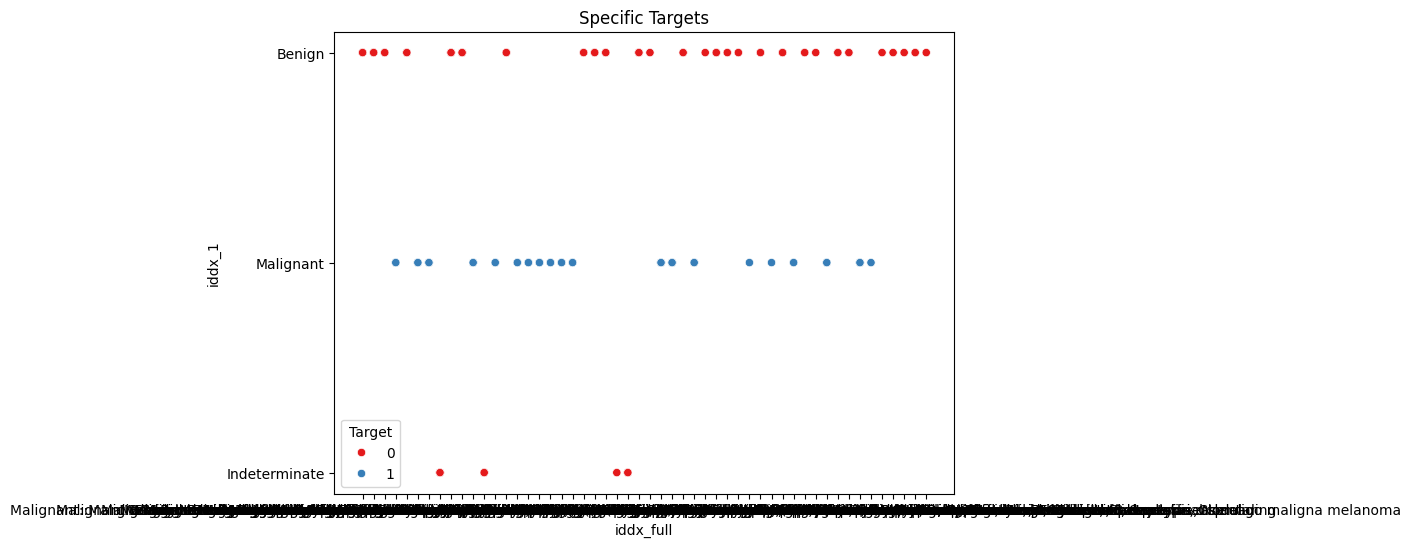

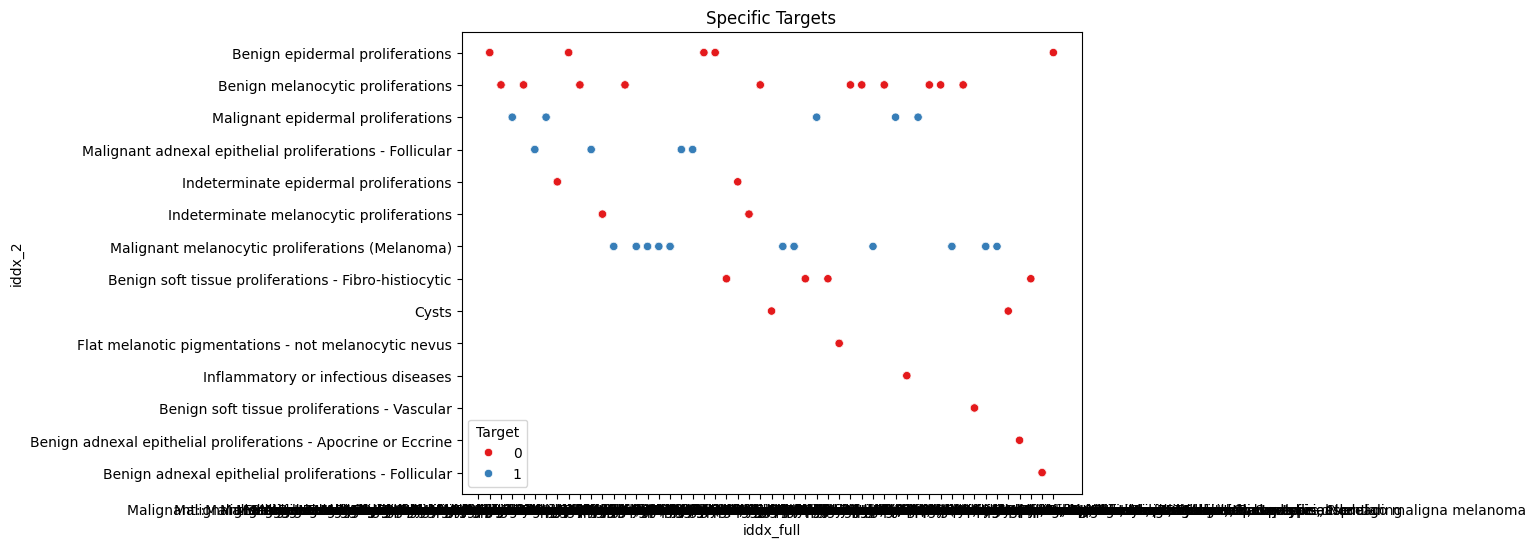

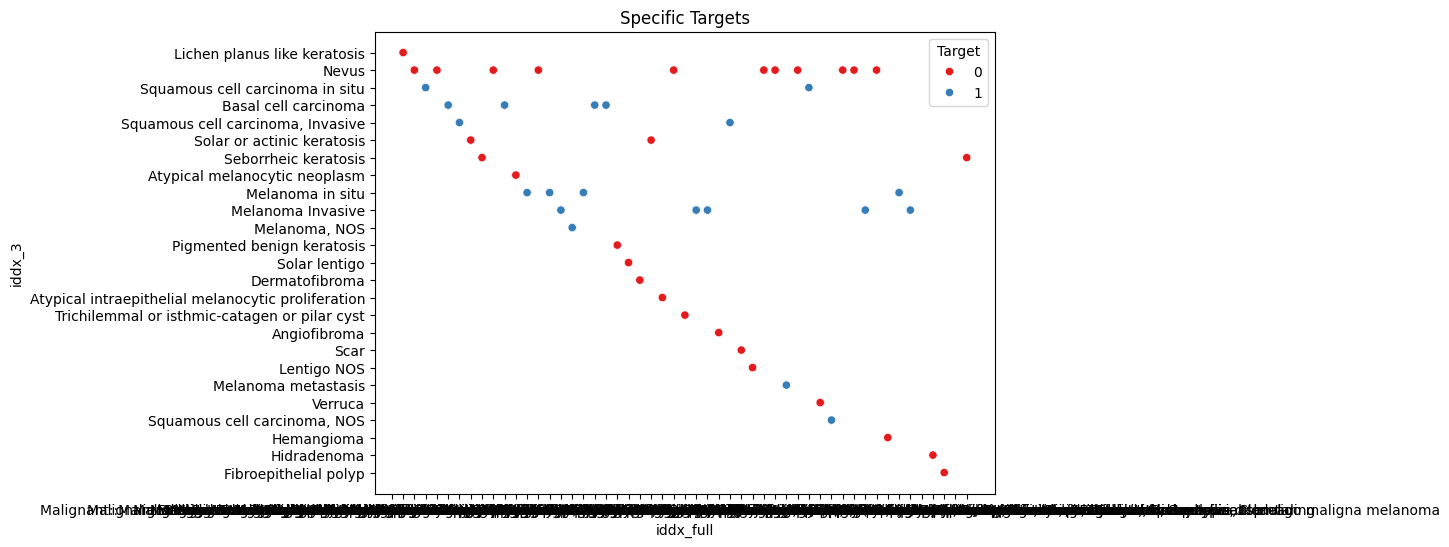

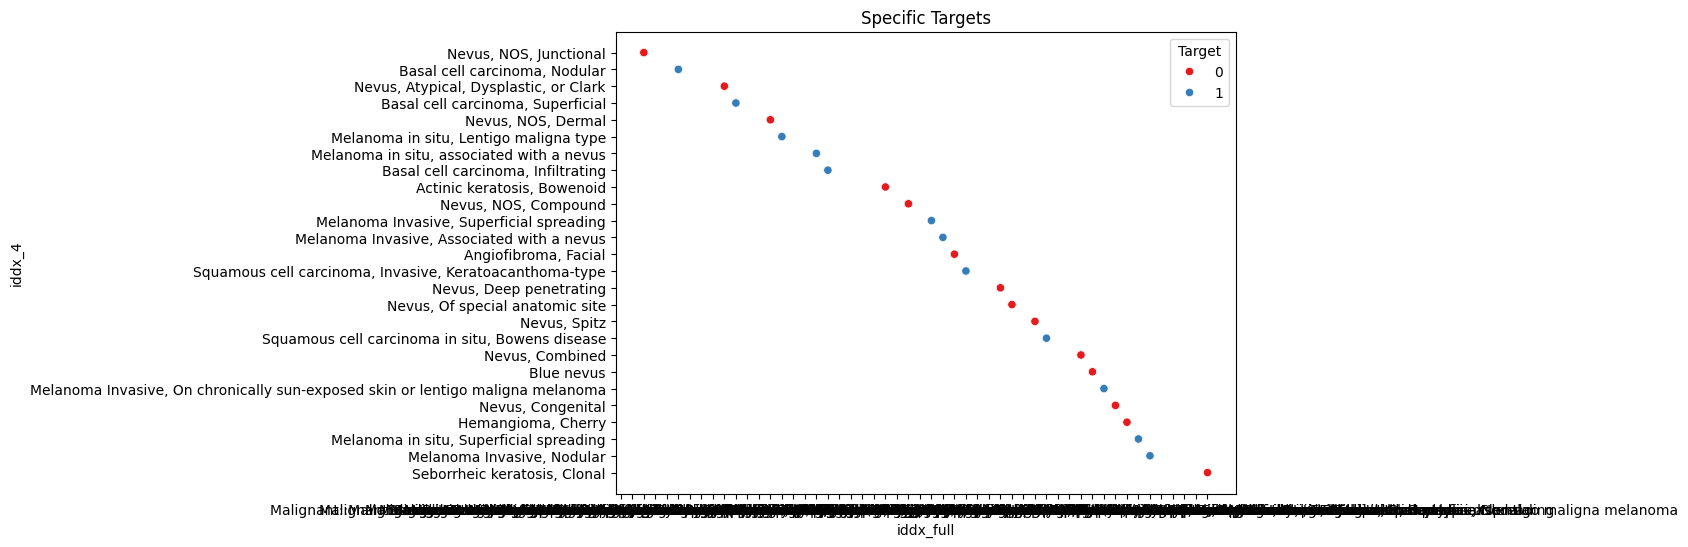

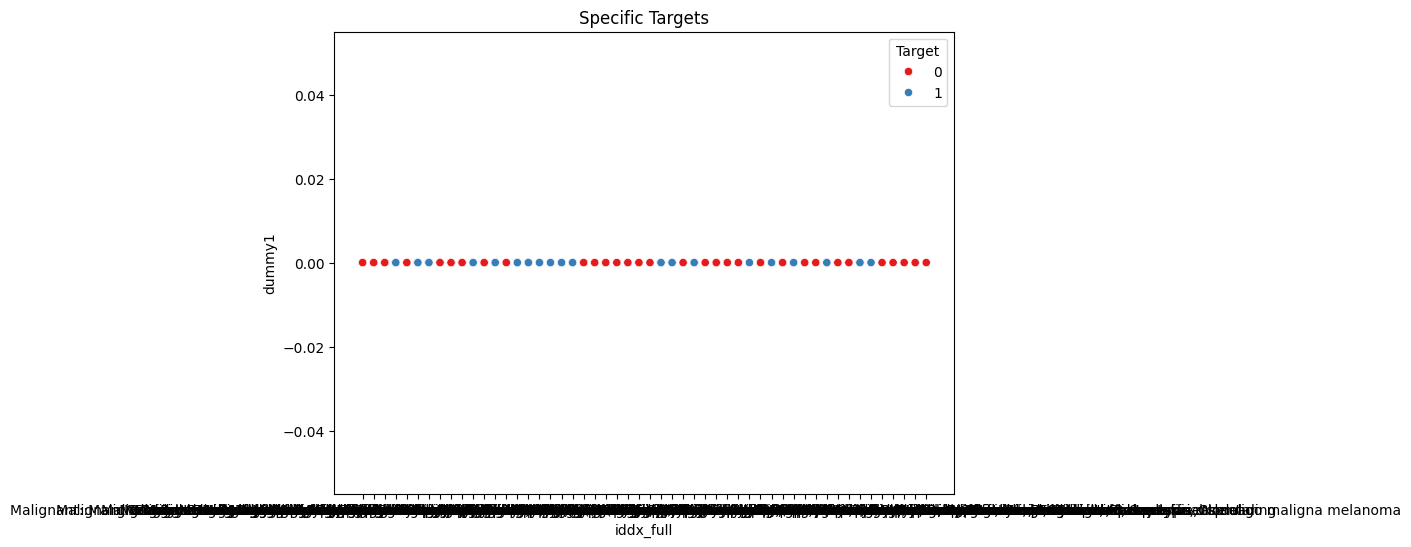

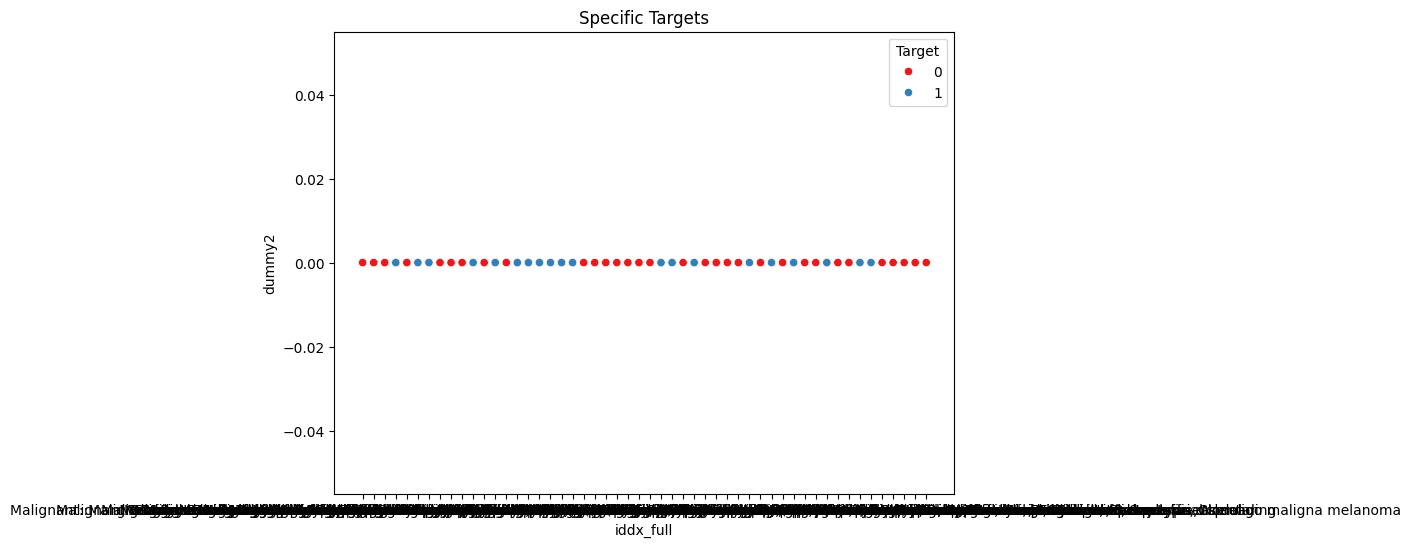

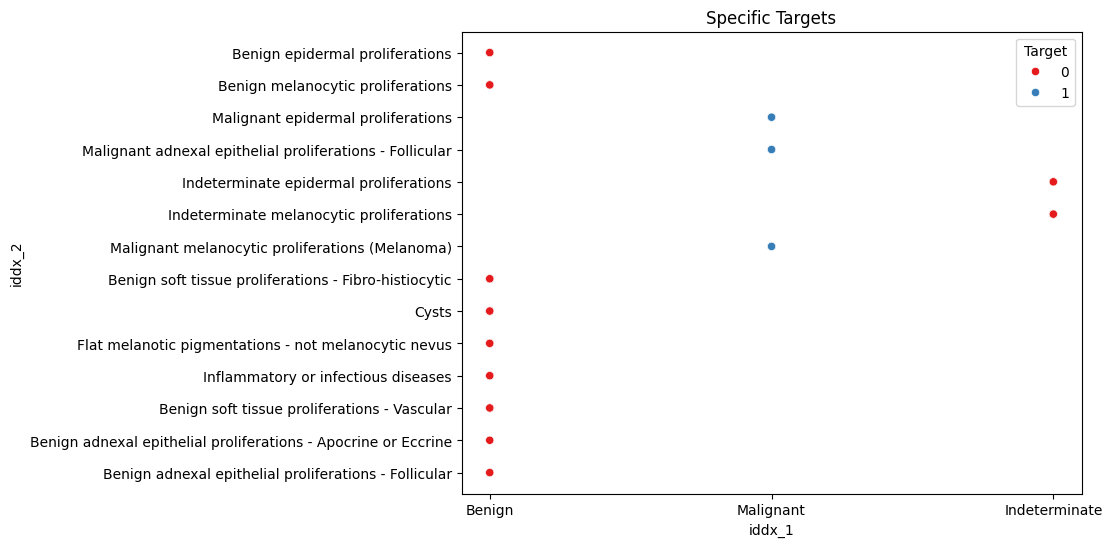

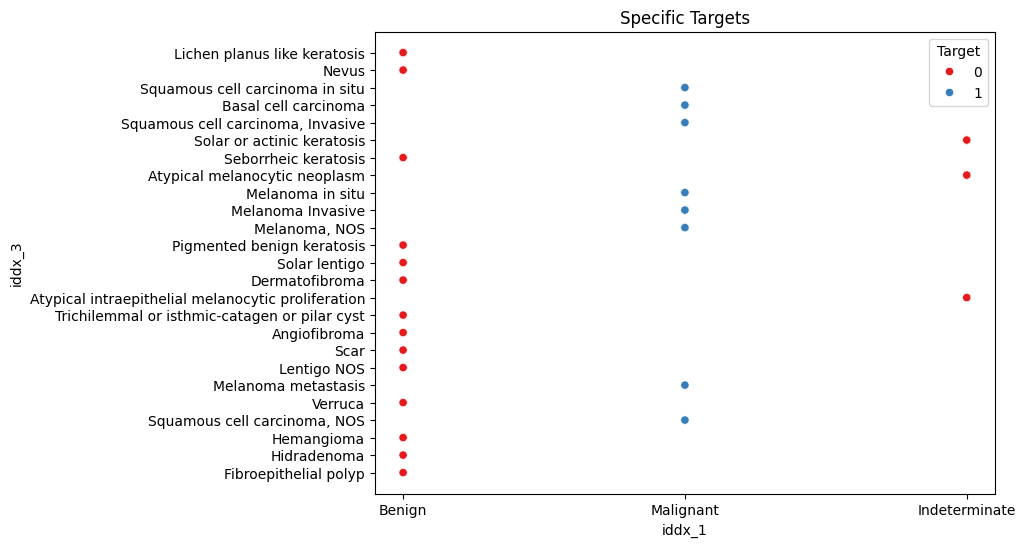

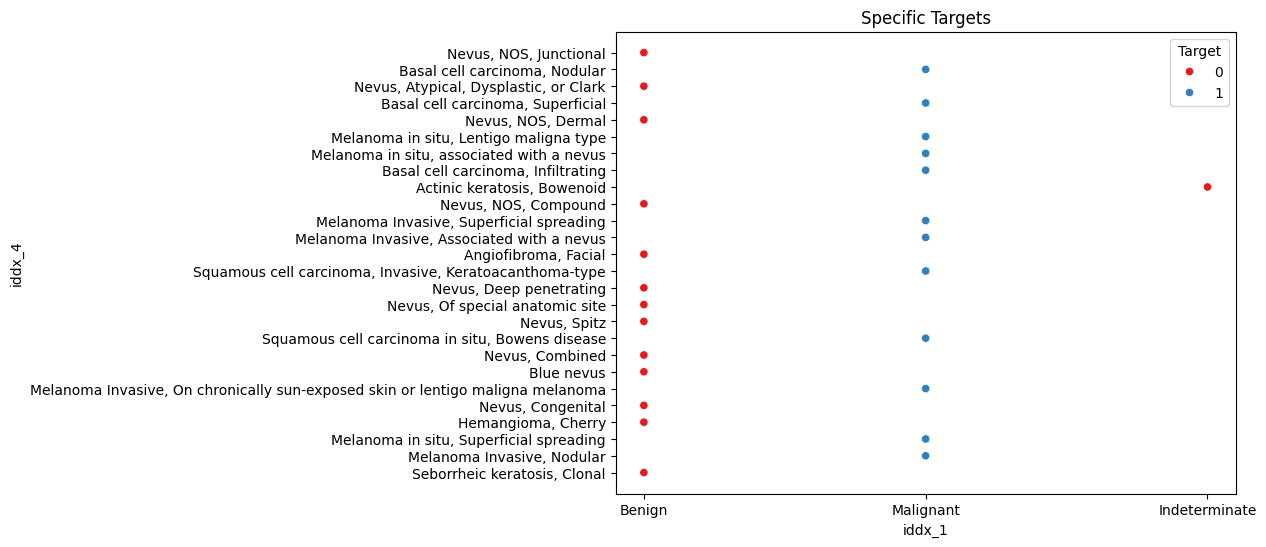

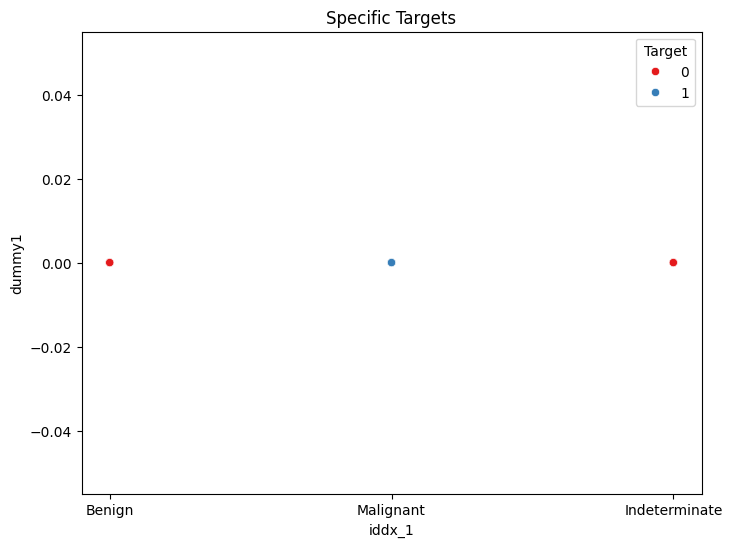

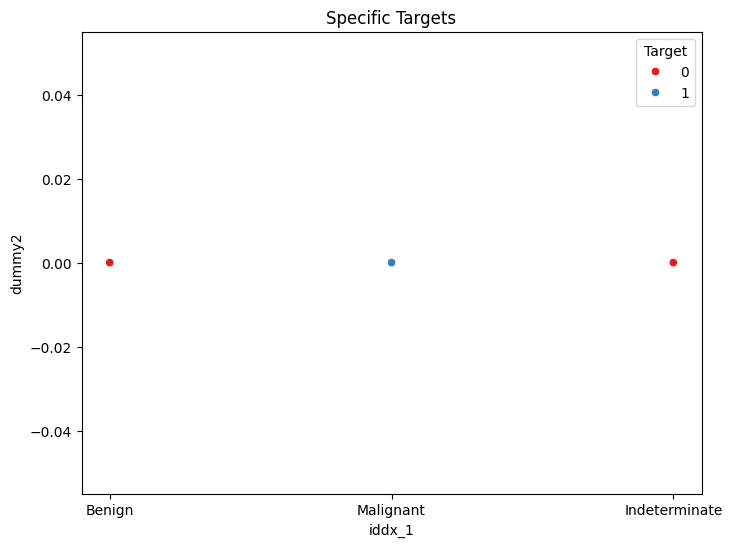

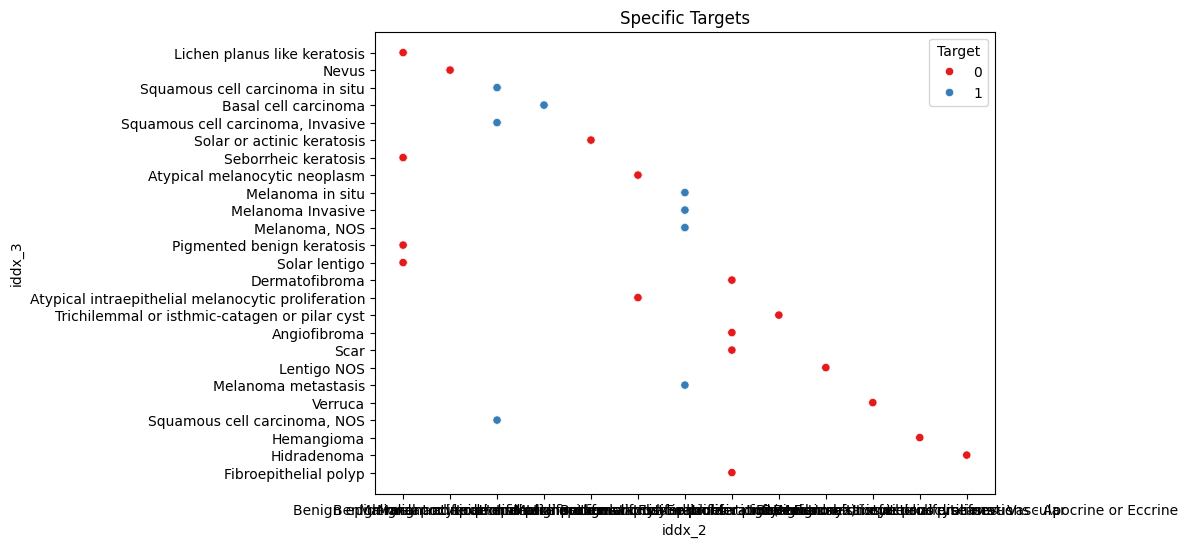

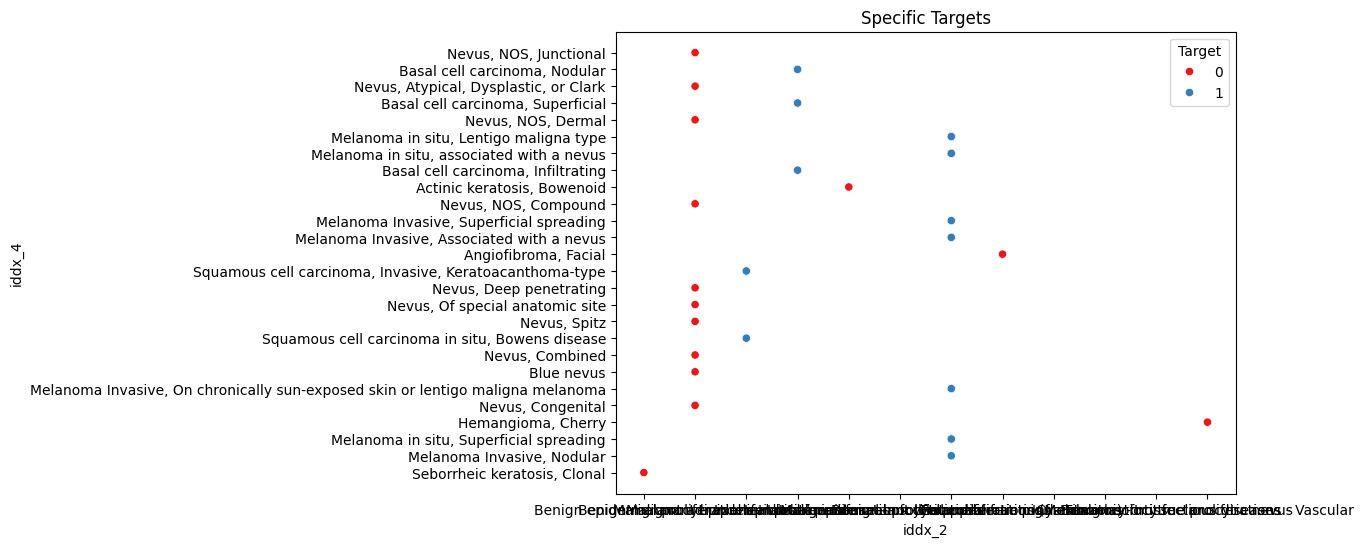

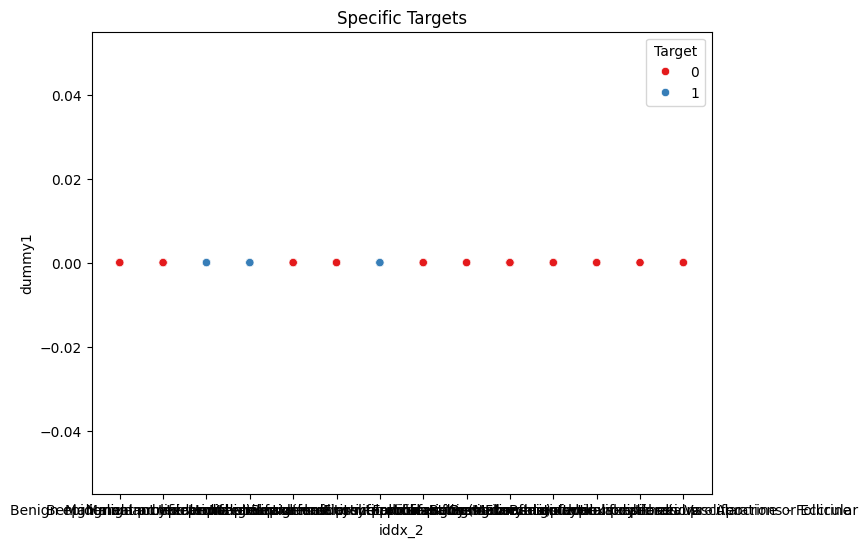

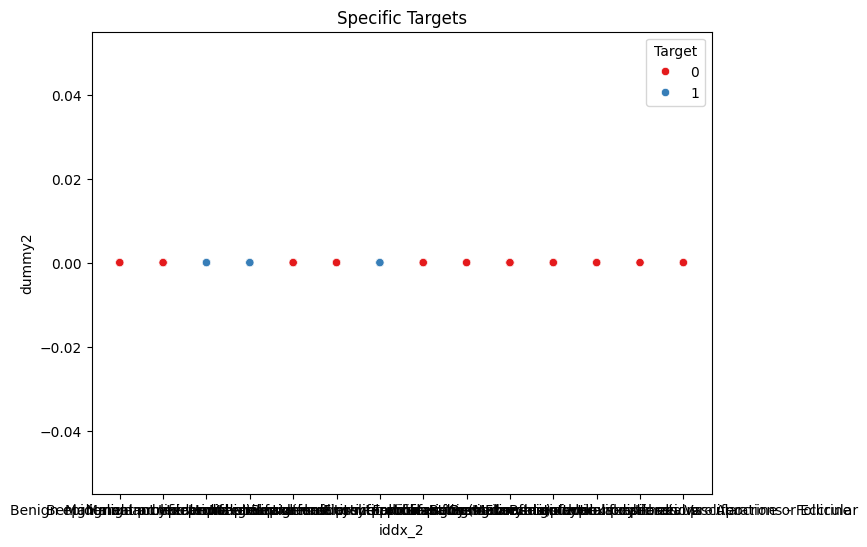

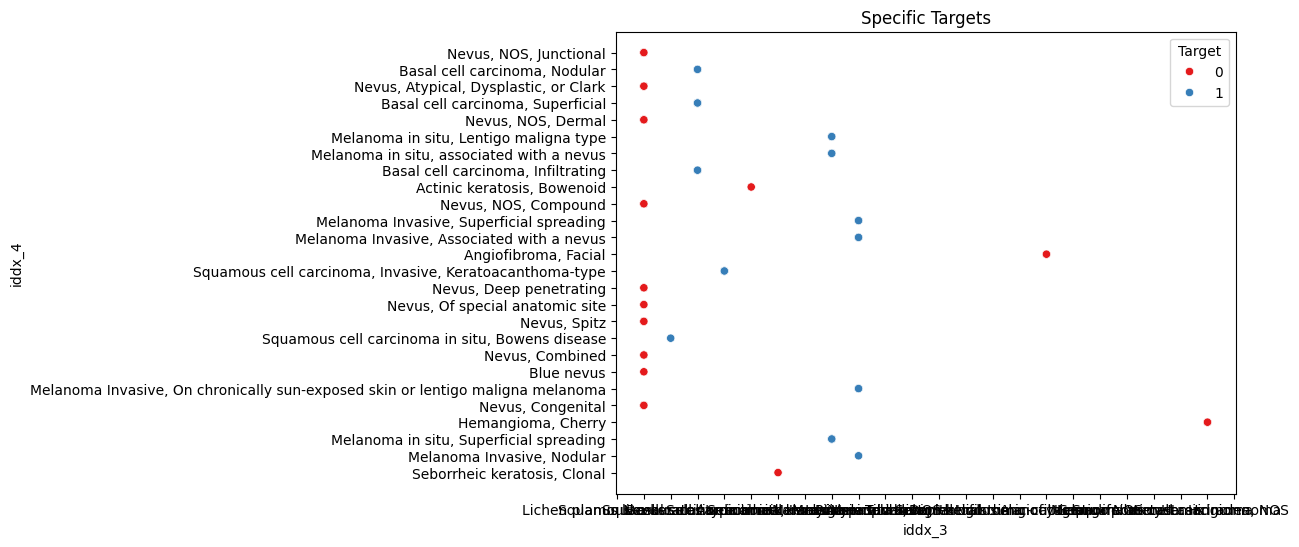

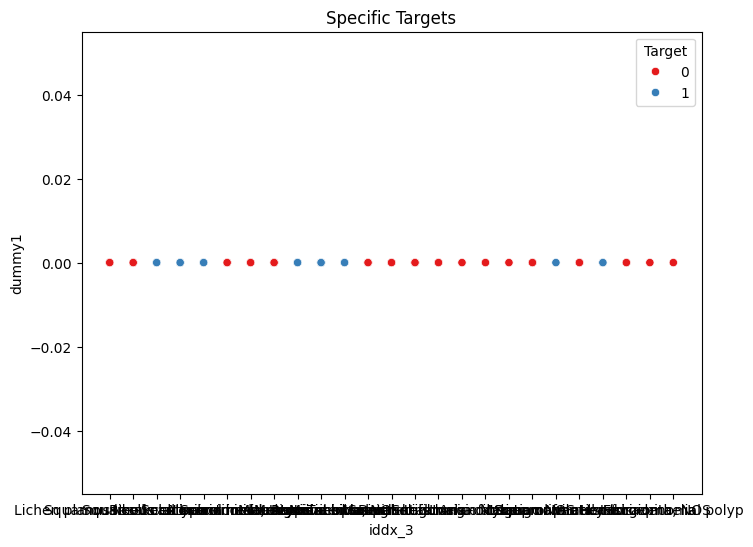

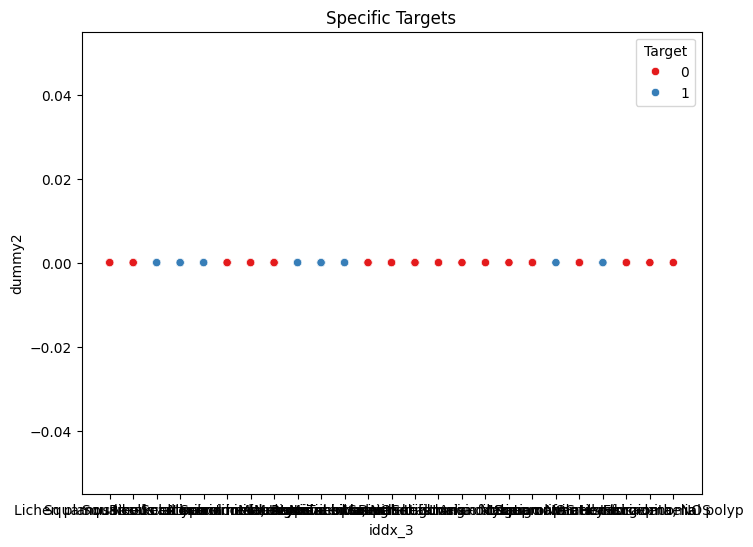

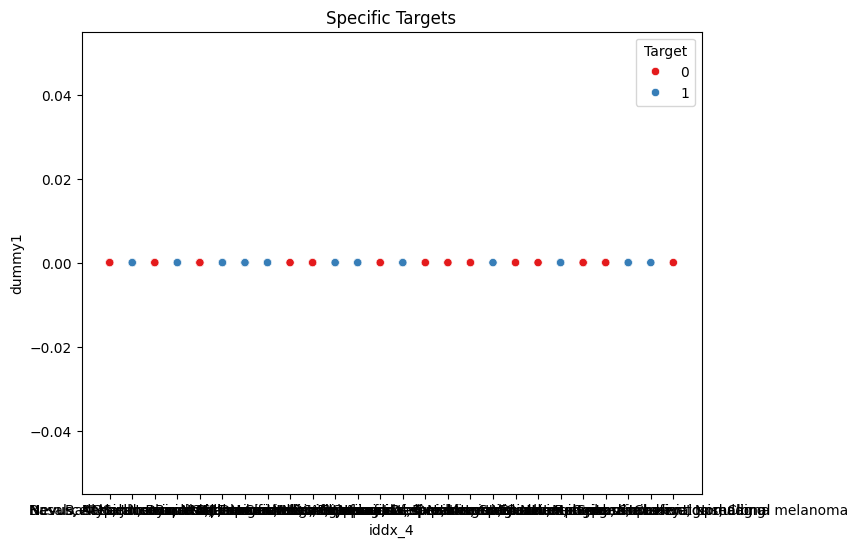

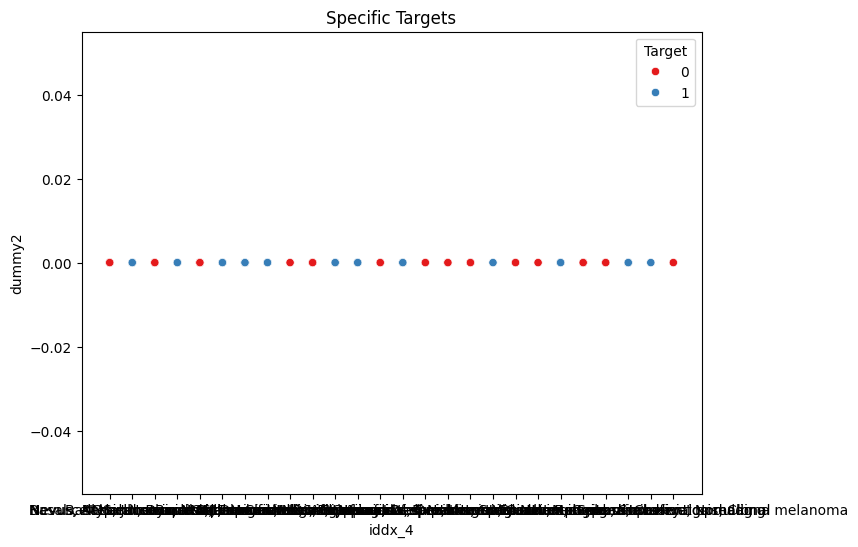

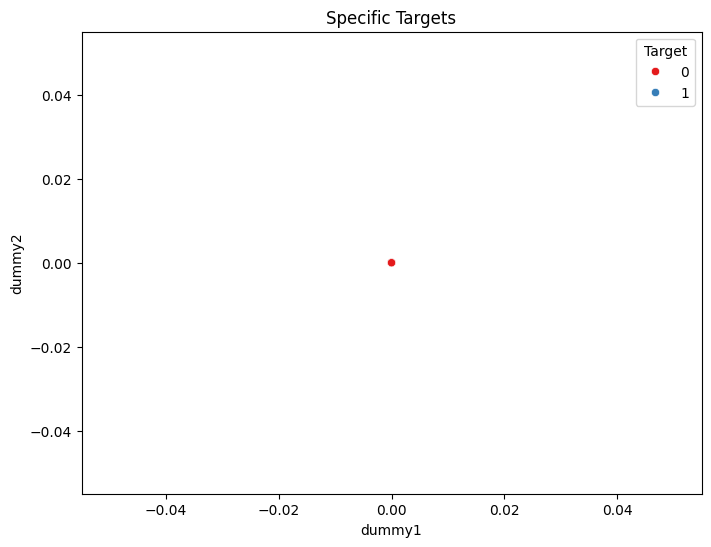

In [49]:
## Targets

targets_iddx = ['target', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'dummy1', 'dummy2']

# add dummy columns to df
df['dummy1'] = 0
df['dummy2'] = 0

for i in range(1,8):
    for j in range(i+1,8):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=targets_iddx[i], y=targets_iddx[j], hue='target', palette='Set1')
        plt.title('Specific Targets')
        plt.xlabel(targets_iddx[i])
        plt.ylabel(targets_iddx[j])
        plt.legend(title='Target')
        plt.show()

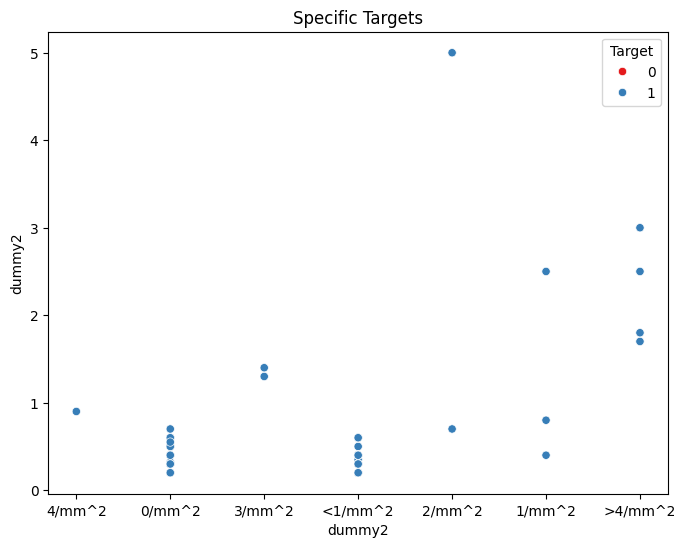

In [50]:
## Targets

## Specific to Target = 1: 'mel_mitotic_index', 'mel_thick_mm'

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='mel_mitotic_index', y= 'mel_thick_mm', hue='target', palette='Set1')
plt.title('Specific Targets')
plt.xlabel(targets_iddx[i])
plt.ylabel(targets_iddx[j])
plt.legend(title='Target')
plt.show()


In [ ]:
# Continuous
cont_cols = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
]